In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.3 MB/s eta 0:00:00


## Step 1: Download images of sports cars and f1 cars

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')

<ipython-input-2-73c3d8b6cec9>:4: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  ddgs = DDGS()


In [3]:
# get URL from search
urls = search_images('nascar car', max_images=1)
urls[0]

Searching for 'nascar car'


'https://mediafeed.org/wp-content/uploads/2019/02/NASCAR_Stock_Car.original.jpg'

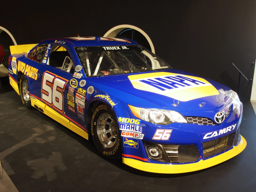

In [4]:
# download URL
from fastdownload import download_url
dest = 'nascar.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Searching for 'f1 car photos'


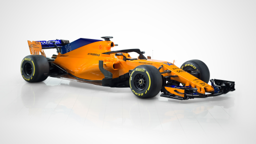

In [5]:
download_url(search_images('f1 car photos', max_images=1)[0], 'f1.jpg', show_progress=False)
Image.open('f1.jpg').to_thumb(256, 256)

In [6]:
# grab few examples of "sports cars" and "f1 cars" photos.
# save each group of photos to a different folder

searches = 'f1 car', 'nascar'
path = Path('sports_car_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} racing photo'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} driving photo'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'f1 car photo'
Searching for 'f1 car racing photo'
Searching for 'f1 car driving photo'
Searching for 'nascar photo'
Searching for 'nascar racing photo'
Searching for 'nascar driving photo'


## Step 2: Train model

In [7]:
# remove incorrectly downloaded photos

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

`DataLoaders` - an object that contains training set(used to create a model) and a validation set(used to check the accuracy of a model)

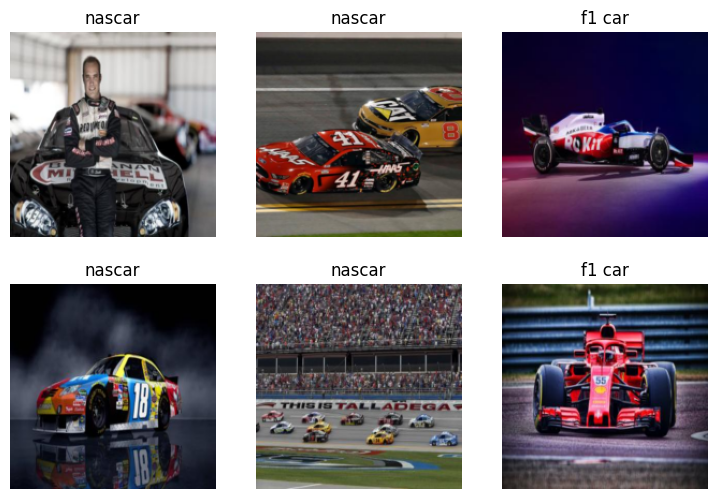

In [8]:
# use DataLoaders to train a model
# and use DataBlock to view sample images

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

`DataBlock` parameters

```python
blocks=(ImageBlock, CateogryBlock),
```
- The inputs to model are images, and the outputs are categories (in this case, "nascar" or "f1" cars).  
<br></br>

```python
get_items=get_image_files,
```
- To find all the inputs to the model, run the `get_image_files` function (which returns a list of all image files in a path).


<br></br>

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```
- Split the data into training and validation sets randomly, using 20% of the data for the validation set.

<br></br>


```python
get_y=parent_label,
```
- The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the foler they're in, which will be nascar or f1).

<br></br>

```python
item_tfms=[Resize(192, method='squish')]
```
- Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).


In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 18.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.084800,0.568459,0.166667,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.334995,0.367859,0.100000,00:01
1,0.265133,0.228749,0.133333,00:00
2,0.235485,0.196836,0.100000,00:00


## Step 3: Use model

In [9]:
is_nascar, _, probs = learn.predict(PILImage.create('nascar.jpg'))
print(f"This is a: {is_nascar}.")
print(f"Probability it's a nascar car: {probs[0]:.4f}")